# Document Clustering

We take the example from scikit-learn (see [here](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py) and run it on these documents.

## Config

In [1]:
n_features = 3000  # How many features in the vector to tell the documents apart?
n_components = 30 # Perform a SVT reduction - improve accuracy
n_cluster = 10 # How many clusters to try to divide things into?

# Setup

In [2]:
from config import text_file_info, extra_stopwords

from collections import defaultdict

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import _check_stop_list
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

stopwords = list(_check_stop_list('english')) + extra_stopwords

## Text loading and vectorizing

Do the regular feature extraction and then reduce the number of components using SVD.

In [3]:
text_by_area = list(text_file_info())

In [4]:
# hasher = HashingVectorizer(input='filename',
#                            n_features=n_features,
#                            stop_words='english',
#                            alternate_sign=False,
#                            norm=None)
# vectorizer = make_pipeline(hasher, TfidfTransformer())
vectorizer = TfidfVectorizer(input='filename',
                             max_df=0.5, max_features=n_features,
                             min_df=2, stop_words=stopwords,
                             use_idf=True)

In [5]:
%%time
x = vectorizer.fit_transform([f[2] for f in text_by_area])

CPU times: user 3.91 s, sys: 806 ms, total: 4.72 s
Wall time: 11.3 s


In [6]:
x.shape

(1566, 3000)

In [7]:
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [8]:
%%time
x_comp = lsa.fit_transform(x)

CPU times: user 2.18 s, sys: 2.24 s, total: 4.41 s
Wall time: 705 ms


## Clustering

Using k-means

In [9]:
km = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=100, n_init=1, verbose=True)

In [10]:
%%time
km.fit(x_comp)

Initialization complete
Iteration 0, inertia 1175.15275912507
Iteration 1, inertia 763.1513042082303
Iteration 2, inertia 750.5177178166416
Iteration 3, inertia 745.8486738825483
Iteration 4, inertia 744.5192911725263
Iteration 5, inertia 743.4877129162209
Iteration 6, inertia 742.8901855667489
Iteration 7, inertia 742.360698002972
Iteration 8, inertia 741.7844717806778
Iteration 9, inertia 741.2214316284831
Iteration 10, inertia 741.0250339071848
Iteration 11, inertia 740.8150972149688
Iteration 12, inertia 740.7305867862867
Iteration 13, inertia 740.6904629377817
Iteration 14, inertia 740.6691013714478
Converged at iteration 14: strict convergence.
CPU times: user 1.95 s, sys: 305 ms, total: 2.25 s
Wall time: 355 ms


KMeans(max_iter=100, n_clusters=10, n_init=1, verbose=True)

Dump some info about each of the clusters we found - in particular, the important terms as we can use that to elminiate terms that shouldn't be a factor here.

In [21]:
def dump_keywords(km, vectorizer, n_clusters):
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()
        
dump_keywords(km, vectorizer, n_cluster)

Cluster 0: lattice qcd quark parton calculations gluon pdfs theory lhc collisions
Cluster 1: higgs decays lhc boson sm collider fcc decay colliders tev
Cluster 2: readout detectors resolution timing silicon pixel mu2e sensors calorimeter tracking
Cluster 3: dark matter dm cosmic cmb galaxy cosmological galaxies lsst survey
Cluster 4: magnet magnets hts superconducting nb3sn conductor dipole rebco cable accelerator
Cluster 5: students accelerator software computing community research science education learning career
Cluster 6: accelerator laser plasma electron rf power collider accelerators bunch srf
Cluster 7: neutrino usa department detectors liquid scintillator nuclear scintillation reactor cherenkov
Cluster 8: quantum axion gravitational dark matter cosmic wave ray gravity black
Cluster 9: neutrino neutrinos dune icecube sterile oscillation oscillations interactions matter scattering


In [22]:
def cluster_df(text_by_area, km):
    cluster_list = []
    for (f_name, f_area, _), i_cluster in zip(text_by_area, km.labels_):
        cluster_list.append({'name': f_name, 'area': f_area, 'cluster': int(i_cluster)})
    return pd.DataFrame(cluster_list)
clusters = cluster_df(text_by_area, km)

In [23]:
clusters

,name,area,cluster
0,SNOWMASS21-AF-TOPIC0-001,AF,6
1,SNOWMASS21-AF0-015,AF,6
2,SNOWMASS21-AF0_AF0-091,AF,6
3,SNOWMASS21-AF0_AF0-215,AF,6
4,SNOWMASS21-AF0_AF0-229,AF,6
...,...,...,...
1561,SNOWMASS21-UF0_UF0_Garcia-Sciveres-001,UF,5
1562,SNOWMASS21-UF1_UF4-RF4_RF3_ODonnell-007,UF,7
1563,SNOWMASS21-UF4_UF3-NF5_NF6-CF1_CF0-IF3_IF0-Com...,UF,7
1564,SNOWMASS21-UF6_UF0-NF10_NF0-RF4_RF0-CF1_CF0-IF...,UF,7


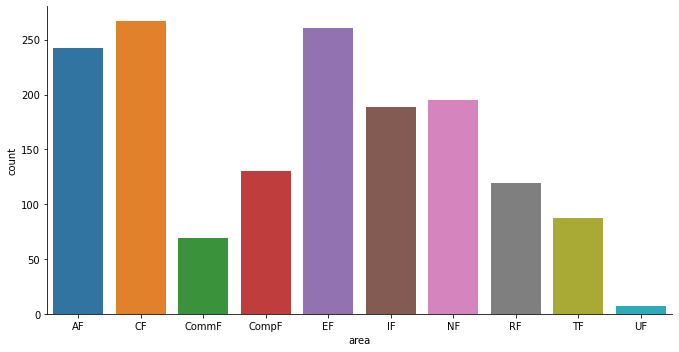

In [14]:
g = sns.catplot('area', kind='count', data=clusters)
g.fig.set_figwidth(10)
g.fig.set_figheight(5)

And how did the clustering do?

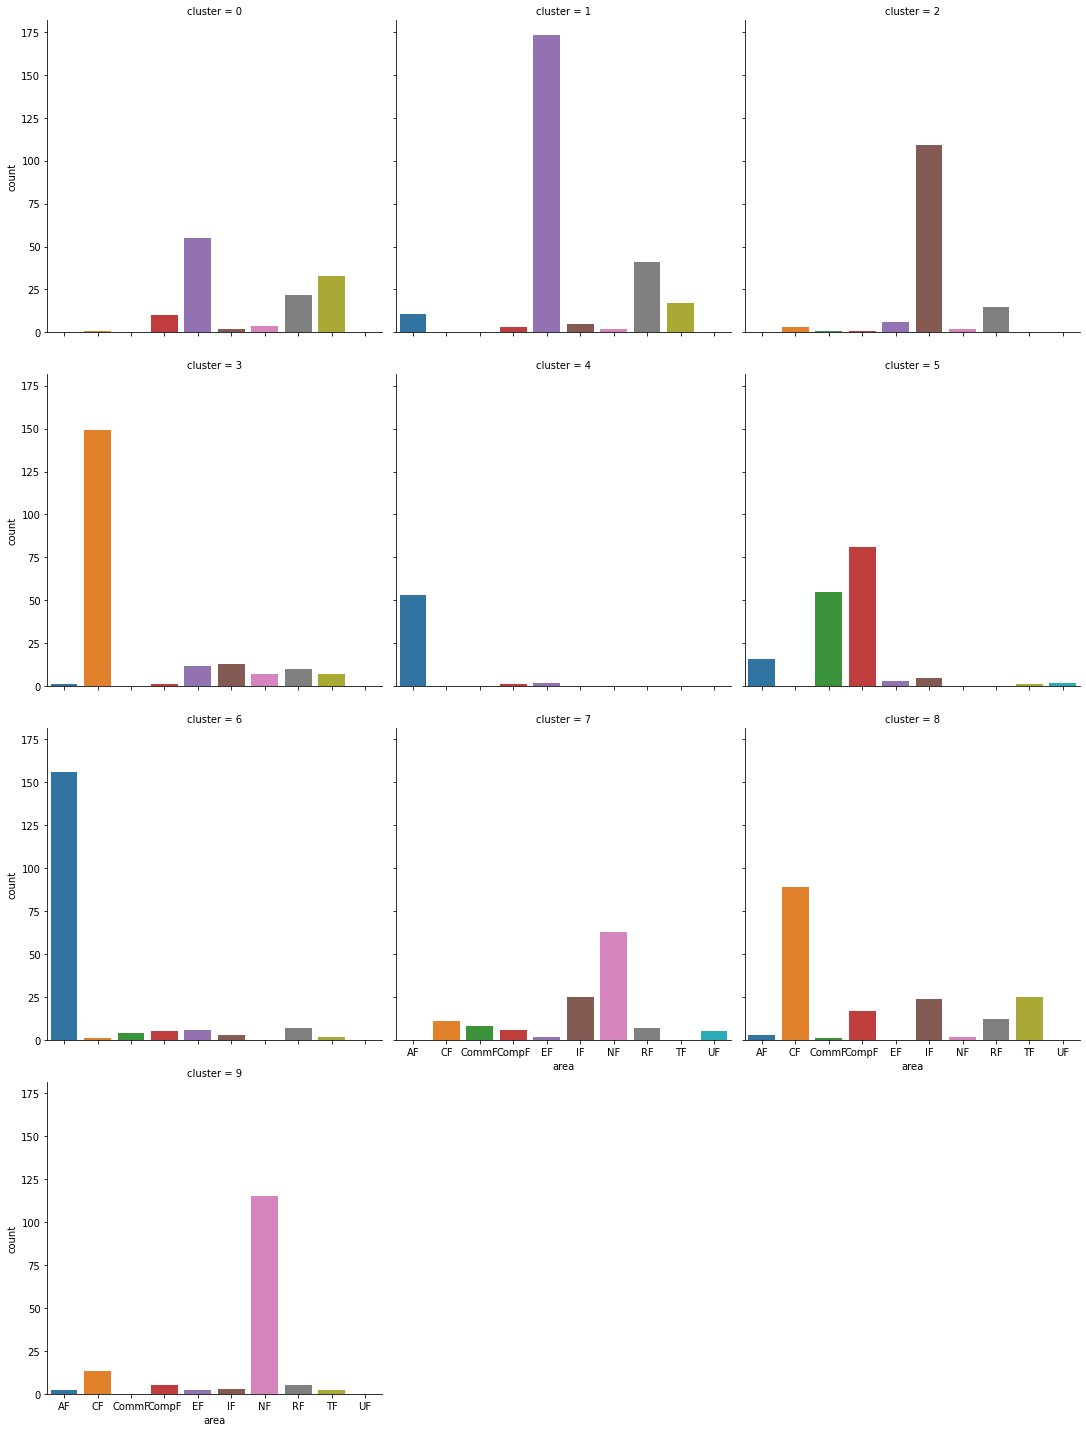

In [15]:
g = sns.catplot('area', kind='count', col='cluster', col_wrap=3, data=clusters)

## Proper number of clusters

To scan for the proper number of clusters we maximize the silhouette score - which is a measure of how inside a datapoint is in each culster vs out far it is from the rest. It ranges from [1,-1].

In [16]:
def cluster_s_score(x_comp, number_of_clusters: int):
    print (f'clustering for {number_of_clusters}')
    km = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, verbose=False, random_state=False)
    km.fit(x_comp)
    return silhouette_score(x_comp, km.labels_)

In [19]:
scan = [(int(n_c), cluster_s_score(x_comp, int(n_c))) for n_c in np.linspace(2, 100, num=30)]

clustering for 2
clustering for 5
clustering for 8
clustering for 12
clustering for 15
clustering for 18
clustering for 22
clustering for 25
clustering for 29
clustering for 32
clustering for 35
clustering for 39
clustering for 42
clustering for 45
clustering for 49
clustering for 52
clustering for 56
clustering for 59
clustering for 62
clustering for 66
clustering for 69
clustering for 72
clustering for 76
clustering for 79
clustering for 83
clustering for 86
clustering for 89
clustering for 93
clustering for 96
clustering for 100


In [20]:
scan

[(2, 0.0806277589258907),
 (5, 0.13885142951542606),
 (8, 0.16187235412584416),
 (12, 0.17930438049488612),
 (15, 0.19246165065400683),
 (18, 0.22918629587872835),
 (22, 0.2344799280129738),
 (25, 0.24502666476338736),
 (29, 0.24407558212430247),
 (32, 0.23965452421386282),
 (35, 0.23342567299228448),
 (39, 0.23037919118792421),
 (42, 0.23370760604111368),
 (45, 0.23228251850106427),
 (49, 0.23704085481161857),
 (52, 0.2313262505364343),
 (56, 0.21909200853037553),
 (59, 0.21284782379856268),
 (62, 0.2082821382131482),
 (66, 0.20434218712158994),
 (69, 0.2013923696999219),
 (72, 0.20226009635500702),
 (76, 0.19935290345896572),
 (79, 0.200993263534288),
 (83, 0.2025364032019049),
 (86, 0.20356060789912905),
 (89, 0.20361407149105878),
 (93, 0.2060026330768456),
 (96, 0.20641023243961848),
 (100, 0.199654784432617)]

In [24]:
best_n = 25
km = KMeans(n_clusters=best_n, init='k-means++', max_iter=100, n_init=1, verbose=False, random_state=False)
km.fit(x_comp)
dump_keywords(km, vectorizer, best_n)

Cluster 0: accelerator rf srf cavities power muon collider electron cavity accelerators
Cluster 1: dark cmb cosmic cosmological matter galaxy redshift lensing surveys dm
Cluster 2: higgs boson sm lhc collider couplings colliders electroweak production cepc
Cluster 3: computing software simulation code analysis hpc community resources accelerator tools
Cluster 4: laser plasma electron accelerator accelerators acceleration bunch wakefield emittance pulse
Cluster 5: neutrino department usa italy detectors dark liquid xenon nuclear di
Cluster 6: lattice qcd calculations quark theory parton pdfs lat calculation nucleon
Cluster 7: neutrino neutrinos dune sterile oscillation reactor oscillations nova interactions experiment
Cluster 8: decays belle decay lhcb sm cp lepton flavor violation rare
Cluster 9: readout detectors resolution timing silicon pixel sensors cepc calorimeter tracking
Cluster 10: dark matter dm detection neutrino particles photon models cosmic searches
Cluster 11: quantum da

In [25]:
best_clusters = cluster_df(text_by_area, km)

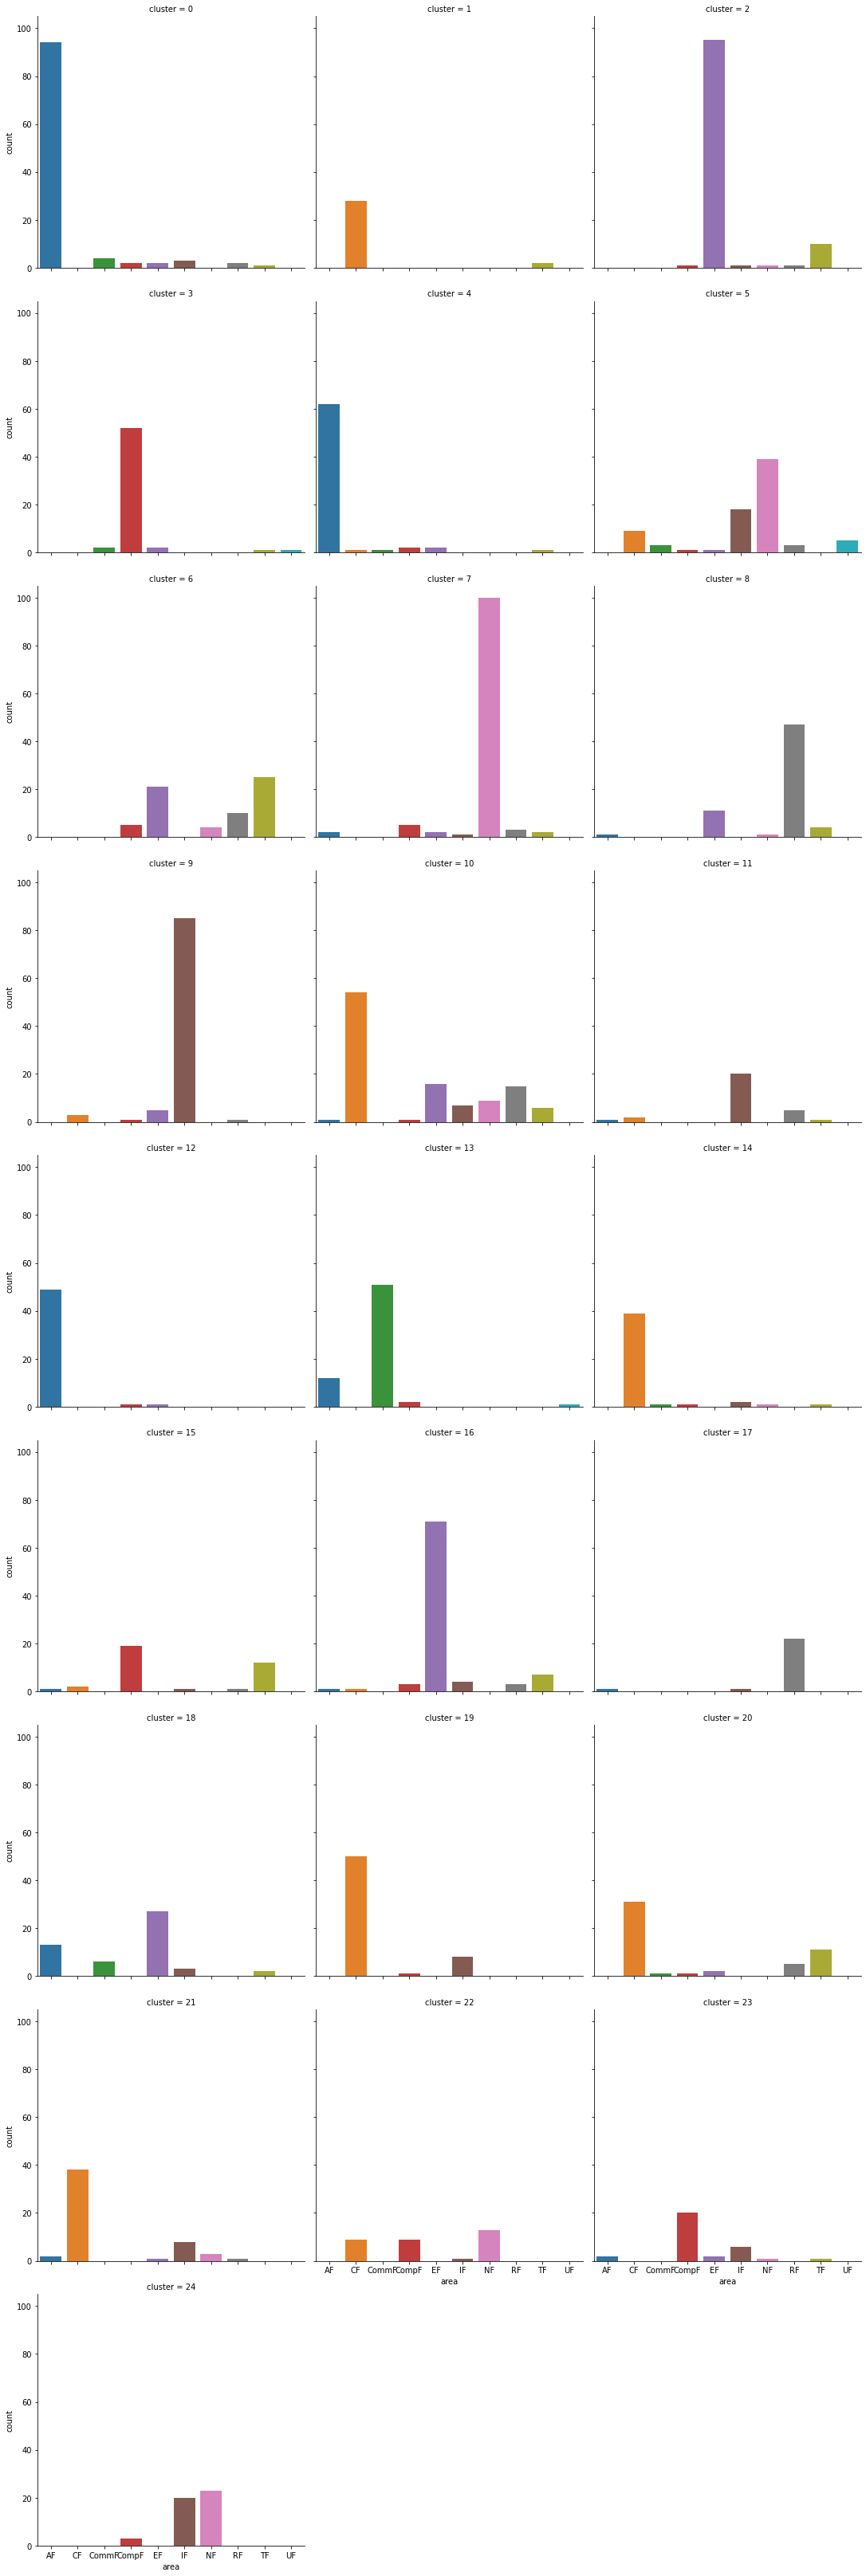

In [27]:
g = sns.catplot('area', kind='count', col='cluster', col_wrap=3, data=best_clusters)